In [1]:
from utils import *
%matplotlib inline

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [3]:
train_data, train_results, test_data, test_results = read_data()

In [4]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor_with_batches(train_data, train_results, test_data, n_estimators_delta, batch_num, split_propotion,
                                         prediction_mode='delta', **est_parameters):
    est = RandomForestRegressor(n_jobs=-1, random_state=0, warm_start=True, n_estimators=n_estimators_delta, **est_parameters)
    
    if prediction_mode == 'delta':
        make_results = make_delta
        unmake_results = unmake_delta
    else:
        make_results = lambda train_data, train_results: train_results
        unmake_results = lambda test_data, prediction: prediction
    
    train_data_ = to_model_with_features(train_data)
    train_results_ = to_model(make_results(train_data, train_results))
    
    n_samples = train_data_.shape[0]
    indices = np.arange(n_samples)
    np.random.seed(seed=0)
    
    for i in range(batch_num):
        np.random.shuffle(indices)
        batch_size = int(split_propotion*n_samples)
        est.fit(train_data_[indices[:batch_size]], train_results_[indices[:batch_size]]) 
        est.n_estimators += n_estimators_delta
    
    prediction = unmake_results(test_data, from_model(est.predict(to_model_with_features(test_data))))
        
    return prediction

In [5]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

2016-12-14 21:17:31: (1, 1)/(4, 4)
2016-12-14 21:22:37: (1, 2)/(4, 4)
2016-12-14 21:30:59: (1, 3)/(4, 4)
2016-12-14 21:42:39: (1, 4)/(4, 4)
2016-12-14 21:59:26: (2, 1)/(4, 4)
2016-12-14 22:05:30: (2, 2)/(4, 4)
2016-12-14 22:15:35: (2, 3)/(4, 4)
2016-12-14 22:30:10: (2, 4)/(4, 4)
2016-12-14 22:51:41: (3, 1)/(4, 4)
2016-12-14 23:00:44: (3, 2)/(4, 4)
2016-12-14 23:14:37: (3, 3)/(4, 4)
2016-12-14 23:35:19: (3, 4)/(4, 4)
2016-12-15 00:06:46: (4, 1)/(4, 4)
2016-12-15 00:18:52: (4, 2)/(4, 4)
2016-12-15 00:38:55: (4, 3)/(4, 4)
2016-12-15 01:06:57: (4, 4)/(4, 4)


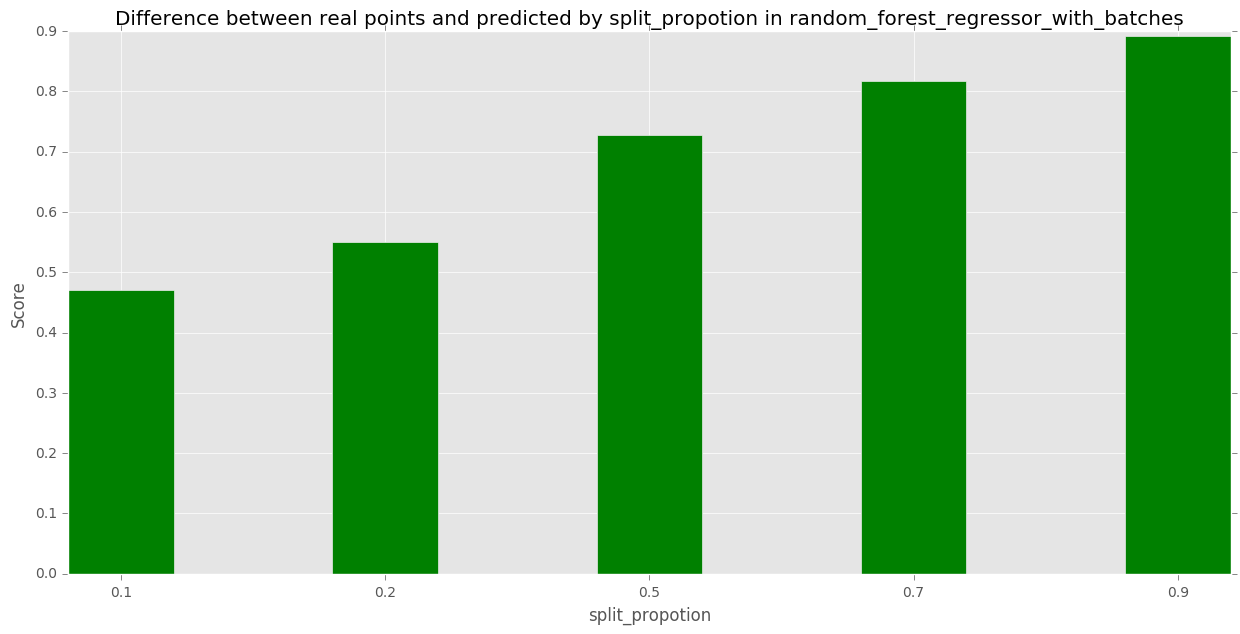

In [7]:
n_est_delta_values = [5, 7, 10, 15]
batch_num_values = [3, 5, 7, 10]
split_propotion_values = [0.1, 0.2, 0.5, 0.7, 0.9]

shape = (len(n_est_delta_values),len(batch_num_values),len(split_propotion_values))
test_score = np.zeros(shape)
train_score = np.zeros(shape)

for i, n_est_delta in enumerate(n_est_delta_values):
    for j, batch_num in enumerate(batch_num_values):
        print("{time}: ({i}, {j})/({i_max}, {j_max})".format(i=i+1, j=j+1, i_max=len(n_est_delta_values),
                                                             j_max=len(batch_num_values),
                                                             time=strftime("%Y-%m-%d %H:%M:%S", localtime())))
        with suppress_stdout():
            test_score[i,j] = compare_results(function=random_forest_regressor_with_batches, test_results=test_results,
                                              parameter_name="split_propotion", list_of_values=split_propotion_values,
                                              train_data=train_data, train_results=train_results, test_data=test_data,
                                              n_estimators_delta=n_est_delta, batch_num=batch_num, prediction_mode='delta')

            train_score[i,j] = compare_results(function=random_forest_regressor_with_batches, test_results=train_results,
                                               parameter_name="split_propotion", list_of_values=split_propotion_values,
                                               train_data=train_data, train_results=train_results, test_data=train_data,
                                               n_estimators_delta=n_est_delta, batch_num=batch_num, prediction_mode='delta')
            
        np.save("src/scores/test_score_{i}_{j}".format(i=i, j=j), test_score[i,j])
        np.save("src/scores/train_score_{i}_{j}".format(i=i, j=j), train_score[i,j])
            
np.save("src/scores/test_score", test_score)
np.save("src/scores/train_score", train_score)

In [4]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor(train_data, train_results, test_data, prediction_mode='delta', **est_parameters):
    est = RandomForestRegressor(n_jobs=-1, random_state=0, **est_parameters)
    
    if prediction_mode == 'delta':
        make_results = make_delta
        unmake_results = unmake_delta
    else:
        make_results = lambda train_data, train_results: train_results
        unmake_results = lambda test_data, prediction: prediction
    
    est.fit(to_model_with_features(train_data), to_model(make_results(train_data, train_results))) 
    prediction = unmake_results(test_data, from_model(est.predict(to_model_with_features(test_data))))
        
    return prediction

1/5: 2016-12-14 18:30:41
2/5: 2016-12-14 18:31:51
3/5: 2016-12-14 18:32:59
4/5: 2016-12-14 18:34:04
5/5: 2016-12-14 18:35:07
done! 2016-12-14 18:36:08
Results: [0.91922071226273883, 0.8959704199260663, 0.85609326788584783, 0.8234742492284598, 0.78614037130941061]


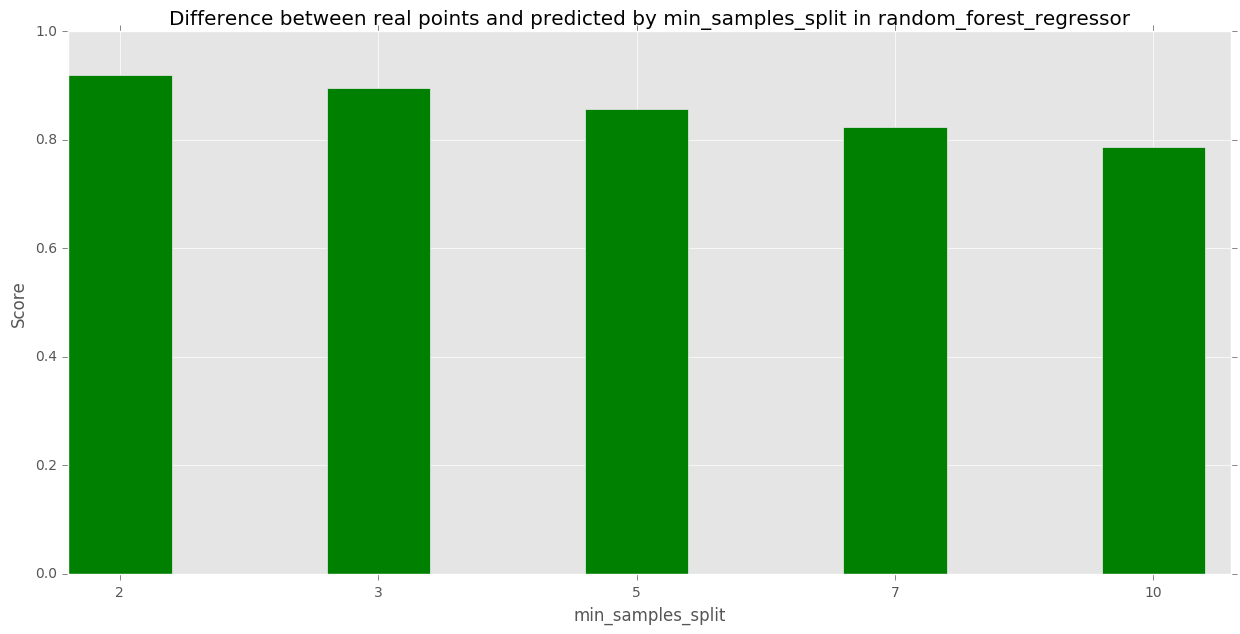

In [5]:
compare_results(function=random_forest_regressor, test_results=train_results, parameter_name="min_samples_split",
                list_of_values=[2, 3, 5, 7, 10], train_data=train_data, train_results=train_results,
                test_data=train_data, prediction_mode='delta', n_estimators=50, max_features=0.4)

1/4: 2016-12-14 18:49:05
2/4: 2016-12-14 18:50:02
3/4: 2016-12-14 18:50:55
4/4: 2016-12-14 18:51:46
done! 2016-12-14 18:52:32
Results: [0.70592220975660536, 0.65729197499344205, 0.5965470610393836, 0.51900225252331489]


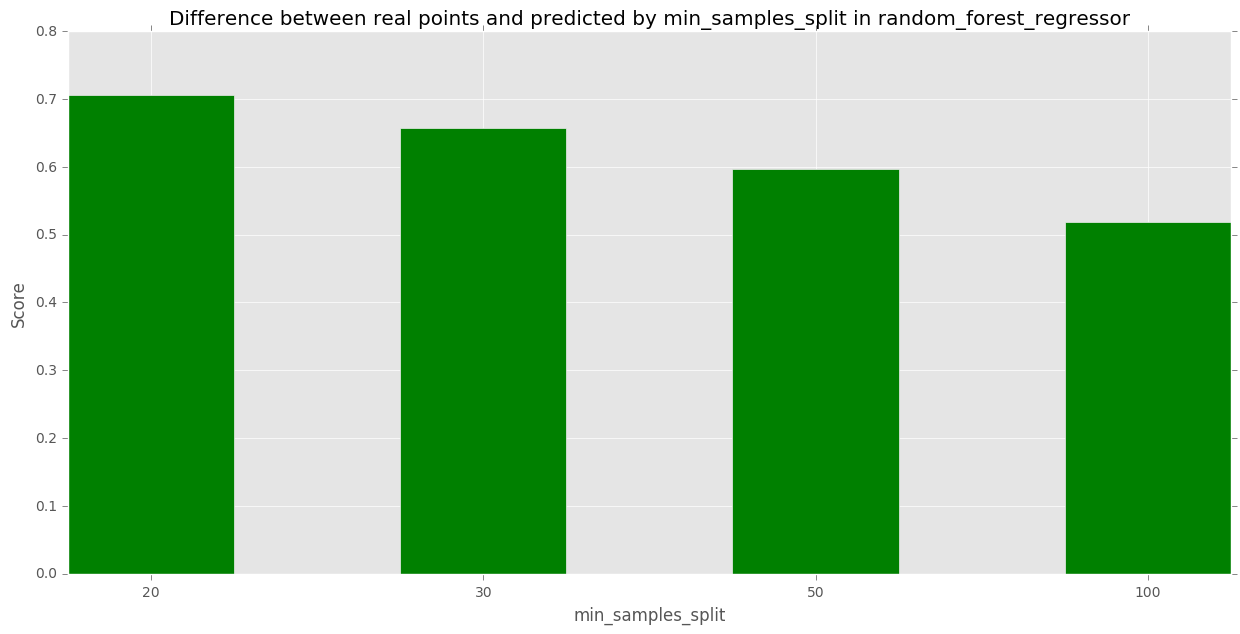

In [10]:
compare_results(function=random_forest_regressor, test_results=train_results, parameter_name="min_samples_split",
                list_of_values=[20, 30, 50, 100], train_data=train_data, train_results=train_results,
                test_data=train_data, prediction_mode='delta', n_estimators=50, max_features=0.4)

1/5: 2016-12-14 18:37:16
2/5: 2016-12-14 18:38:24
3/5: 2016-12-14 18:39:29
4/5: 2016-12-14 18:40:31
5/5: 2016-12-14 18:41:32
done! 2016-12-14 18:42:31
Results: [0.41815957151219385, 0.41840639322205919, 0.41943254825264786, 0.42029247147849014, 0.41964768663336105]


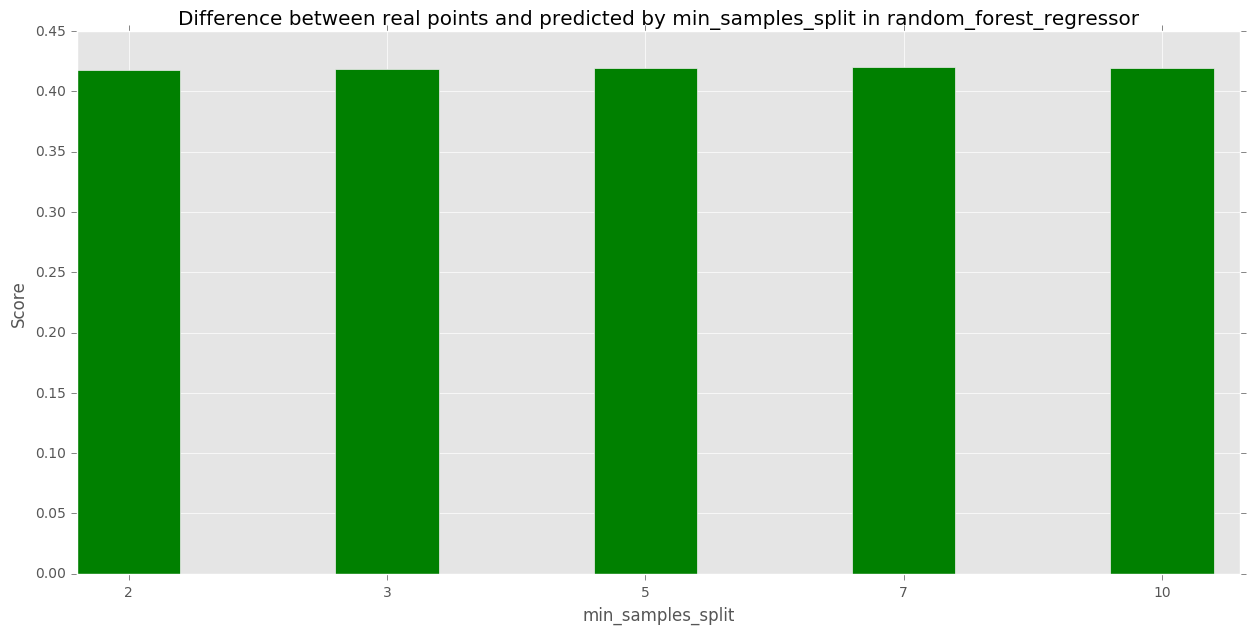

In [6]:
compare_results(function=random_forest_regressor, test_results=test_results, parameter_name="min_samples_split",
                list_of_values=[2, 3, 5, 7, 10], train_data=train_data, train_results=train_results,
                test_data=test_data, prediction_mode='delta', n_estimators=50, max_features=0.4)

1/4: 2016-12-14 18:44:30
2/4: 2016-12-14 18:45:25
3/4: 2016-12-14 18:46:17
4/4: 2016-12-14 18:47:06
done! 2016-12-14 18:47:50
Results: [0.41602458873703652, 0.41428761021747129, 0.4073512770042268, 0.39362359575587991]


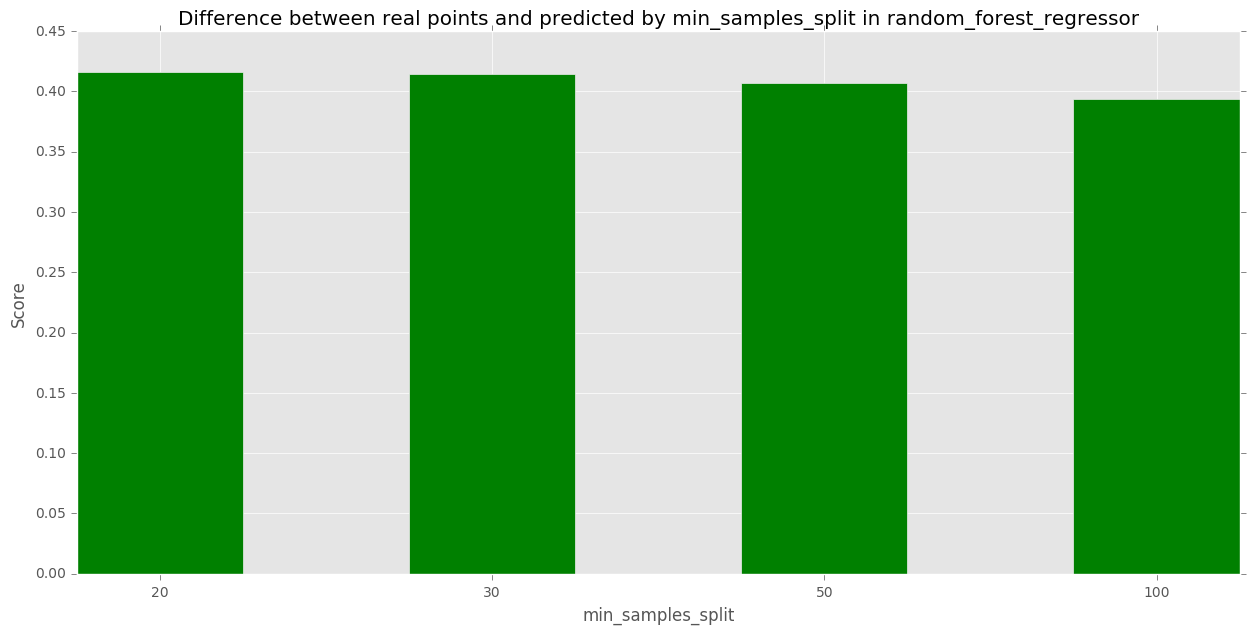

In [8]:
compare_results(function=random_forest_regressor, test_results=test_results, parameter_name="min_samples_split",
                list_of_values=[20, 30, 50, 100], train_data=train_data, train_results=train_results,
                test_data=test_data, prediction_mode='delta', n_estimators=50, max_features=0.4)